In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(sys.version_info)

2.3.0
sys.version_info(major=3, minor=7, micro=1, releaselevel='final', serial=0)


In [2]:
# 1. preprocessing
# 2.build model
## 2.1 encoder
## 2.2 attention
## 2.3 decoder
#3. evaluation
## 3.1 given sentence return
## 3.2 visulize results

In [3]:
en_spa_file_path = "input/spa.txt"

import unicodedata
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

unicode_to_ascii("¿Quién corrió?")

'¿Quien corrio?'

In [4]:
import re
def preprocess_sentence(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([?.!,¿])", r" \1 ", s)
    s = re.sub(r'[" "]+', " ", s)
    s = re.sub(r'[^a-zA-Z?.!,¿]', " ", s)
    
    s= s.rstrip().strip()
    
    s = '<start> ' + s + ' <end>'
    return s

preprocess_sentence("¿Quién corrió?")

'<start> ¿ quien corrio ? <end>'

In [5]:
def parse_data(filename):
    lines = open(filename, encoding="UTF-8").read().strip().split("\n")
    sentence_pairs = [line.split("\t") for line in lines]
    preprocessed_sentence_pairs = [
        (preprocess_sentence(en), preprocess_sentence(sp)) for en, sp in sentence_pairs
    ]
    return zip(*preprocessed_sentence_pairs)

en_dataset, sp_dataset = parse_data(en_spa_file_path)

In [6]:
## id
def tokenizer(lang):
    lang_tokenizer = keras.preprocessing.text.Tokenizer(num_words=None, filters="", split=" ")
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')
    return tensor, lang_tokenizer

input_tensor, input_tokenizer = tokenizer(sp_dataset[0:30000])
output_tensor, output_tokenizer = tokenizer(en_dataset[0:30000])

def max_length(tensor):return max(len(t) for t in tensor)

max_length_input = max_length(input_tensor)
max_length_output = max_length(output_tensor)
print(max_length_input, max_length_output)

16 11


In [7]:
from sklearn.model_selection import train_test_split
input_train, input_eval, output_train, output_eval = train_test_split(input_tensor, output_tensor, test_size=0.2)

In [8]:
def convert(example, tokenizer):
    for t in example:
        if t != 0:
            print("%d --> %s"%(t, tokenizer.index_word[t]))


In [9]:
def make_dateset(input_tensor, output_tensor, batch_size, epochs, shuffle):
    dataset = tf.data.Dataset.from_tensor_slices((input_tensor, output_tensor))
    if shuffle:
        dataset = dataset.shuffle(30000)
    dataset = dataset.repeat(epochs).batch(batch_size, drop_remainder=True)
    return dataset

batch_size = 64
epochs = 5
train_dataset = make_dateset(input_train, output_train, batch_size, epochs, True)
eval_dataset = make_dateset(input_eval, output_eval, batch_size, 1, False)

In [10]:
for x, y in train_dataset.take(1):
    pass

In [11]:
embedding_units = 128
units = 512
input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1

In [12]:
class Encoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, encoding_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = keras.layers.GRU(self.encoding_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform'
        )
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))

encoder = Encoder(input_vocab_size, embedding_units, units, batch_size)

sample_hidden = encoder.initialize_hidden_state()

sample_output, sample_hidden = encoder(x, sample_hidden)

print("sample_output.shape: ", sample_output.shape)
print("sample_hidden.shape: ", sample_hidden.shape)

sample_output.shape:  (64, 16, 512)
sample_hidden.shape:  (64, 512)


In [13]:
class BahanauAttention(keras.Model):
    def __init__(self, units):
        super(BahanauAttention, self).__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)

    def call(self, decoder_hidden, encoder_outputs):
        # deocoder_hidden.shape:(batch_size, units)
        # encoder_output.shape: (batch_size, length, units)
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)
        
        # before: (batch_size, length, units)
        # after:  (batch_size, length, 1)
        score = self.V(
            tf.nn.tanh(
                self.W1(encoder_outputs) + self.W2(decoder_hidden_with_time_axis)))
        
        # shape: (batch_size, length, 1)
        attention_weights = tf.nn.softmax(score, axis = 1)
        
        # context_vector.shape: (batch_size, length, units)
        context_vector = attention_weights * encoder_outputs
        
        #context_vector.shape: (batch, units) 
        context_vector = tf.reduce_sum(context_vector, axis = 1)
        
        return context_vector, attention_weights
    

attention_model = BahanauAttention(units = 10)
attention_results, attention_weights = attention_model(sample_hidden, sample_output)

print("attention results.shape:", attention_results.shape)
print("attention weights.shape:", attention_weights.shape)

attention results.shape: (64, 512)
attention weights.shape: (64, 16, 1)


In [14]:
class Decoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, 
                 decoding_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru= keras.layers.GRU(self.decoding_units, 
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.fc = keras.layers.Dense(vocab_size)
        
        self.attention = BahanauAttention(self.decoding_units)
        
        
    def call(self, x, hidden, encoding_outputs):
        # context_vecot.shape: (batch_size, units)
        context_vector, attention_weights = self.attention(
            hidden, encoding_outputs
         )
        # before embedding: x.shape: (batch_size, 1)
        
        # after embdding: x.shape: (batch_size, 1, embedding_units)
        x = self.embedding(x)
        combined_x = tf.concat(
            [tf.expand_dims(context_vector, 1), x], axis = -1)
        
        output, state = self.gru(combined_x)
        
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output.shape [batch_size, vocab_size]
        output = self.fc(output)
        
        return output, state, attention_weights
    
decoder = Decoder(output_vocab_size, embedding_units, units, batch_size)
outputs = decoder(tf.random.uniform((batch_size, 1)), sample_hidden, sample_output)

decoder_output, decoder_hidden, decoder_aw = outputs

print("decoder_output shape:", decoder_output.shape)
print("decoder_hidden shape:", decoder_hidden.shape)
print("decoder_attention_weights.shape:", decoder_aw.shape)

decoder_output shape: (64, 4935)
decoder_hidden shape: (64, 512)
decoder_attention_weights.shape: (64, 16, 1)


In [15]:
optimizer = keras.optimizers.Adam()

loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none")

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [16]:
@tf.function
def train_step(inp, targ, encoding_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        encoding_outputs, encoding_hidden = encoder(inp, encoding_hidden)
        decoding_hidden = encoding_hidden
        
        # eg: <start> I am here <end>
        # 1. <start> -> I
        # 4. here -> <end>
        for t in range(0, targ.shape[1] - 1):
            decoding_input = tf.expand_dims(targ[:, t], 1)
            predictions, decoding_hidden, _ = decoder(decoding_input, decoding_hidden, encoding_outputs)
            loss += loss_function(targ[:,t+1], predictions)
            
    batch_loss = loss/int(targ.shape[0])
    variables = encoder.trainable_variables + decoder.trainable_variables # list +
    
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [17]:
epochs = 5
steps_per_epoch = len(input_tensor) // batch_size

for epoch in range(epochs):
    start = time.time()
    encoding_hidden = encoder.initialize_hidden_state()
    
    total_loss = 0
    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, encoding_hidden)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))

    print("Epoch {} Loss {:.4f}".format(epoch +1, total_loss/steps_per_epoch))
    
    print("Time take for 1 epoch {} sec\n".format(time.time() - start))

Epoch 1 Batch 0 Loss 0.8139
Epoch 1 Batch 100 Loss 0.3915
Epoch 1 Batch 200 Loss 0.3571
Epoch 1 Batch 300 Loss 0.3353
Epoch 1 Batch 400 Loss 0.3007
Epoch 1 Loss 0.3754
Time take for 1 epoch 246.4912497997284 sec

Epoch 2 Batch 0 Loss 0.3026
Epoch 2 Batch 100 Loss 0.2631
Epoch 2 Batch 200 Loss 0.2680
Epoch 2 Batch 300 Loss 0.2210
Epoch 2 Batch 400 Loss 0.2396
Epoch 2 Loss 0.2652
Time take for 1 epoch 226.71780467033386 sec

Epoch 3 Batch 0 Loss 0.2259
Epoch 3 Batch 100 Loss 0.2166
Epoch 3 Batch 200 Loss 0.2078
Epoch 3 Batch 300 Loss 0.2090
Epoch 3 Batch 400 Loss 0.1782
Epoch 3 Loss 0.2038
Time take for 1 epoch 229.55093097686768 sec

Epoch 4 Batch 0 Loss 0.1629
Epoch 4 Batch 100 Loss 0.1695
Epoch 4 Batch 200 Loss 0.1796
Epoch 4 Batch 300 Loss 0.1665
Epoch 4 Batch 400 Loss 0.1259
Epoch 4 Loss 0.1568
Time take for 1 epoch 229.23765397071838 sec

Epoch 5 Batch 0 Loss 0.1131
Epoch 5 Batch 100 Loss 0.1216
Epoch 5 Batch 200 Loss 0.1184
Epoch 5 Batch 300 Loss 0.1294
Epoch 5 Batch 400 Loss 0.10

In [27]:
def evaluate(input_sentence):
    attention_matrix = np.zeros((max_length_output, max_length_input))
    input_sentence = preprocess_sentence(input_sentence)
    
    inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(" ")]
    
    inputs = keras.preprocessing.sequence.pad_sequences([inputs], maxlen= max_length_input, padding="post")

    inputs = tf.convert_to_tensor(inputs)
    
    results = ""
#     encoding_hidden = encoder.initialize_hidden_state()
    encoding_hidden = tf.zeros((1, units))
    
    encoding_outputs, encoding_hidden = encoder(inputs, encoding_hidden)
    
    decoding_hidden = encoding_hidden
    
    # eg: <start> -> A
    # A -> B -> C -> D
    
    decoding_input = tf.expand_dims(
        [output_tokenizer.word_index["<start>"]], 0
    )
    
    for t in range(max_length_output):
        predictions, decoding_hidden, attention_weights = decoder(decoding_input, decoding_hidden, encoding_outputs)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        
        attention_matrix[t] = attention_weights.numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        results += output_tokenizer.index_word[predicted_id] + " "
        
        if output_tokenizer.index_word[predicted_id] == "<end>":
            return results, input_sentence, attention_matrix
        
        decoding_input = tf.expand_dims([predicted_id], 0)
        
    return results, input_sentence, attention_matrix

In [28]:
def plot_attention(attention_matrix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    ax.matshow(attention_matrix, cmap = "viridis")
    
    font_dict = {'fontsize': 14}
    
    ax.set_xticklabels([""] + input_sentence, fontdict = font_dict, rotation = 90)
    ax.set_yticklabels([""] + predicted_sentence, fontdict = font_dict)
    
    plt.show()
    
def translate(input_sentence):
    results, input_sentence, attention_matrix = evaluate(input_sentence)
    print("Input: %s"% (input_sentence))
    print("Predicted translation: %s" % (results))
    
    attention_matrix = attention_matrix[:len(results.split(" ")), :len(input_sentence.split(" "))]
    
    plot_attention(attention_matrix, input_sentence.split(" "), results.split(" "))

Input: <start> hace mucho frio aqui <end>
Predicted translation: it s very hot here . <end> 


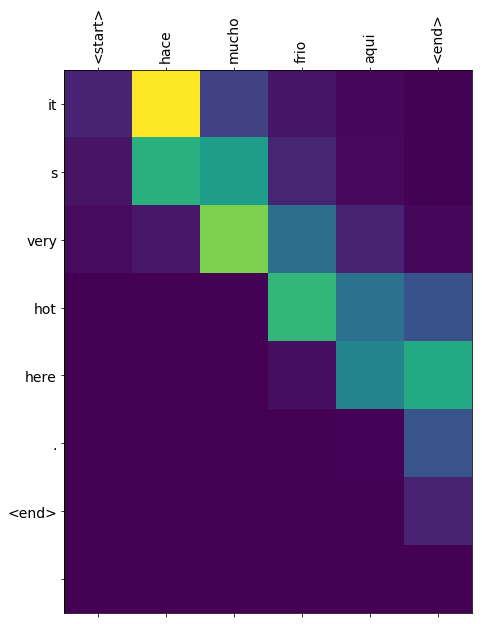

In [29]:
translate(u"hace mucho frío aquí")